# <a id='toc1_'></a>[Estimation de dépense en électricité en fonction des abonnements EDF](#toc0_)
## Tarifs du 1er Aout & 14 Septembre 2023

**Table of contents**<a id='toc0_'></a>
- [Estimation de dépense en électricité en fonction des abonnements EDF](#toc1_)
    - [Imports fonctions & fichiers](#toc1_1)
    - [Définiton des Fonctions](#toc1_2)
    - [Définiton des Imputs](#toc1_3)
    - [Définiton des Imputs](#toc1_4)
        - [NaN](#toc1_4_1) 
        - [Séparation à la demi heure](#toc1_4_2) 
        - [Ajout des informations hc / we / tempo](#toc1_4_3)
    - [Calcul des différents coûts](#toc1_5)

## <a id='toc1_1'></a>[Imports fonctions & fichiers](#toc0_)

In [137]:
import os
import pandas as pd
import numpy as np

import seaborn as sns  
import matplotlib.pyplot as plt

import datetime as dt
from datetime import datetime

In [143]:
file = pd.read_csv('./data/Enedis_Conso_Heure_20221221-20230820_02198263279373.csv', sep=";")

In [144]:
tarif_base = pd.read_csv('./data/tarifs/tarif_base.csv', sep=";")
tarif_hc = pd.read_csv('./data/tarifs/tarif_hc.csv', sep=";")
tarif_tempo = pd.read_csv('./data/tarifs/tarif_tempo.csv', sep=";")
tarif_zen_we = pd.read_csv('./data/tarifs/tarif_zen_we.csv', sep=";")
tarif_zen_we_hc =  pd.read_csv('./data/tarifs/tarif_zen_we_hc.csv', sep=";")
tempo_days = pd.read_csv("./data/tempo_days.csv", sep=";")

In [145]:
data = file.iloc[2:,0:2]
data.rename(columns={'Identifiant PRM': "Horaire", "Type de donnees": "Puissance"}, inplace=True)

data.reset_index(drop=True)

,Horaire,Puissance
0,2022-12-21T01:00:00+01:00,157
1,2022-12-21T02:00:00+01:00,114
2,2022-12-21T03:00:00+01:00,758
3,2022-12-21T04:00:00+01:00,238
4,2022-12-21T05:00:00+01:00,267
...,...,...
11354,2023-08-19T22:00:00+02:00,508
11355,2023-08-19T22:30:00+02:00,512
11356,2023-08-19T23:00:00+02:00,374
11357,2023-08-19T23:30:00+02:00,468


## <a id='toc1_2'></a>[Definition des Fonctions](#toc0_)

In [146]:
def split_hours(df):
    new_rows = []
    all_horaires = pd.to_datetime(df['Horaire'])
    
    for index, row in df.iterrows():
        horaire = pd.to_datetime(row['Horaire'])
        puissance = int(row['Puissance'])
        last_half_hour = horaire - pd.Timedelta(minutes=30)
        
        # Si le relevé est à l'heure et que le précédent n'est pas 30 minutes avant
        if horaire.minute == 0 and last_half_hour not in all_horaires.values:
            new_rows.append({'Horaire': last_half_hour, 'Puissance': puissance})
            new_rows.append({'Horaire': horaire, 'Puissance': puissance})
        else:  # Si le relevé est déjà à la demi-heure
            new_rows.append({'Horaire': horaire, 'Puissance': puissance})

    new_df = pd.DataFrame(new_rows)
    return new_df

In [147]:
def convert_string_to_time(str):
    if len(str) < 4:
        return dt.time(hour=int(str[0]), minute=int(str[1:3]))
    else:
        return dt.time(hour=int(str[0:2]), minute=int(str[3:5]))

In [148]:
def set_we(data):
    data["WE"] = False
    
    # Parcourir chaque ligne du DataFrame
    for index, row in data.iterrows():
        horaire = row['Horaire'].weekday()

        # Comparer l'horaire avec les horaires de début et de fin
        if 5 <= horaire <= 6:
            data.loc[index, 'WE'] = True
            
    return data

In [149]:
def set_hc(data, hc_start, hc_stop, name_hc):
    """Convertir les horaires de début et de fin en objets time
    """
    hc_start = convert_string_to_time(hc_start)
    hc_stop = convert_string_to_time(hc_stop)
    daytime = False
    
    if hc_start < hc_stop:
        daytime = True

    # Ajouter une colonne au DataFrame pour stocker les booléens
    data[name_hc] = False

    # Parcourir chaque ligne du DataFrame
    for index, row in data.iterrows():
        horaire = row['Horaire'].time()

        # Si heure creuse jour
        if daytime == True:
            # Comparer l'horaire avec les horaires de début et de fin
            if hc_start <= horaire and horaire < hc_stop:
                data.loc[index, name_hc] = True
                
        # Si heure creuse nuit (entre j et j+1)
        else:
            # Comparer l'horaire avec les horaires de début et de fin
            if hc_start <= horaire or horaire < hc_stop:
                data.loc[index, name_hc] = True

    return data

In [150]:
def set_blue_white_red(data):
    blanc = tempo_days['Tempo_blanc'].dropna()
    rouge = tempo_days['Tempo_rouge'].dropna()
    
    tempo_blanc = [datetime.strptime(date, "%d/%m/%Y").date() for date in blanc]
    tempo_rouge = [datetime.strptime(date, "%d/%m/%Y").date() for date in rouge]
    
    # Ajouter une colonne au DataFrame pour stocker les booléens
    data['tempo_blanc'] = False
    data['tempo_rouge'] = False
    
    # Parcourir chaque ligne du DataFrame
    for index, row in data.iterrows():
        horaire = row['Horaire'].date()
        
        if horaire in tempo_blanc:
            data.loc[index, 'tempo_blanc'] = True
        elif horaire in tempo_rouge:
            data.loc[index, 'tempo_rouge'] = True
    
    return data

In [151]:
def abo_cost(data, abo):
    month_start = data["Horaire"].iloc[0].month
    month_stop = data["Horaire"].iloc[-1].month
    year_start = data["Horaire"].iloc[0].year
    year_stop = data["Horaire"].iloc[-1].year

    cost = abo * ((year_stop - year_start) * 12 + month_stop - month_start)
    return cost

In [152]:
def prix_base(data, puissance, tarif):
    abo = tarif.loc[tarif['Puissance Souscrite'] == puissance, 'Abonnement']
    abo_tot = abo_cost(data, abo)
    
    tarif_kwh = tarif.loc[tarif['Puissance Souscrite'] == puissance, 'Prix'] / 100
    sum_kwh = data['Puissance'].sum() / 2000
    
    prix_base = abo_tot + tarif_kwh * sum_kwh
    
    return {'Abonnement': 'Base', 'Coût Total': round(prix_base, 2)}

In [153]:
def prix_hc(data, puissance,  tarif):
    abo = tarif.loc[tarif['Puissance Souscrite'] == puissance, 'Abonnement']
    abo_tot = abo_cost(data, abo)
    
    tarif_kwh_hp = tarif.loc[tarif['Puissance Souscrite'] == puissance, 'Prix HP'] / 100
    tarif_kwh_hc = tarif.loc[tarif['Puissance Souscrite'] == puissance, 'Prix HC'] / 100
    
    sum_kwh_hp = data['Puissance'].loc[data['HC_EDF'] == False].sum() / 2000
    sum_kwh_hc = data['Puissance'].loc[data['HC_EDF'] == True].sum() / 2000
    
    prix_hc = abo_tot + tarif_kwh_hp * sum_kwh_hp + tarif_kwh_hc * sum_kwh_hc
    
    return {'Abonnement': 'Heures Creuses', 'Coût Total': round(prix_hc, 2)}

In [154]:
def prix_tempo(data, puissance,  tarif):
    abo = tarif.loc[tarif['Puissance Souscrite'] == puissance, 'Abonnement']
    abo_tot = abo_cost(data, abo)
    
    tarif_kwh_hp_bleu = tarif.loc[tarif['Puissance Souscrite'] == puissance, 'Prix Bleu HP'] / 100
    tarif_kwh_hc_bleu = tarif.loc[tarif['Puissance Souscrite'] == puissance, 'Prix Bleu HC'] / 100
    tarif_kwh_hp_blanc = tarif.loc[tarif['Puissance Souscrite'] == puissance, 'Prix Blanc HP'] / 100
    tarif_kwh_hc_blanc = tarif.loc[tarif['Puissance Souscrite'] == puissance, 'Prix Blanc HC'] / 100
    tarif_kwh_hp_rouge = tarif.loc[tarif['Puissance Souscrite'] == puissance, 'Prix Rouge HP'] / 100
    tarif_kwh_hc_rouge = tarif.loc[tarif['Puissance Souscrite'] == puissance, 'Prix Rouge HC'] / 100
    
    sum_kwh_hp_bleu = data['Puissance'].loc[(data['HC_tempo'] == False)
                                            & (data['tempo_blanc'] == False)
                                            & (data['tempo_rouge'] == False)].sum() / 2000
    sum_kwh_hc_bleu = data['Puissance'].loc[(data['HC_tempo'] == True)
                                            & (data['tempo_blanc'] == False)
                                            & (data['tempo_rouge'] == False)].sum() / 2000
    sum_kwh_hp_blanc = data['Puissance'].loc[(data['HC_tempo'] == False)
                                            & (data['tempo_blanc'] == True)].sum() / 2000
    sum_kwh_hc_blanc = data['Puissance'].loc[(data['HC_tempo'] == True)
                                            & (data['tempo_blanc'] == True)].sum() / 2000
    sum_kwh_hp_rouge = data['Puissance'].loc[(data['HC_tempo'] == False)
                                            & (data['tempo_rouge'] == True)].sum() / 2000
    sum_kwh_hc_rouge = data['Puissance'].loc[(data['HC_tempo'] == True)
                                            & (data['tempo_rouge'] == True)].sum() / 2000
    
    prix_tempo = (abo_tot + 
                  tarif_kwh_hp_bleu * sum_kwh_hp_bleu + 
                  tarif_kwh_hc_bleu * sum_kwh_hc_bleu +
                  tarif_kwh_hp_blanc * sum_kwh_hp_blanc + 
                  tarif_kwh_hc_blanc * sum_kwh_hc_blanc +
                  tarif_kwh_hp_rouge * sum_kwh_hp_rouge + 
                  tarif_kwh_hc_rouge * sum_kwh_hc_rouge)
    
    return {'Abonnement': 'Tempo', 'Coût Total': round(prix_tempo, 2)}

In [155]:
def prix_zen_we(data, puissance, tarif):
    abo = tarif.loc[tarif['Puissance Souscrite'] == puissance, 'Abonnement']
    abo_tot = abo_cost(data, abo)
    
    tarif_kwh_hp = tarif.loc[tarif['Puissance Souscrite'] == puissance, 'Prix HP'] / 100
    tarif_kwh_hc = tarif.loc[tarif['Puissance Souscrite'] == puissance, 'Prix HC'] / 100
    
    sum_kwh_hp = data['Puissance'].loc[data['WE'] == False].sum() / 2000
    sum_kwh_hc = data['Puissance'].loc[data['WE'] == True].sum() / 2000
    
    prix_zen_we = abo_tot + tarif_kwh_hp * sum_kwh_hp + tarif_kwh_hc * sum_kwh_hc
    
    return {'Abonnement': 'Zen Week-end', 'Coût Total': round(prix_zen_we, 2)}

In [156]:
def prix_zen_we_hc(data, puissance, tarif):
    abo = tarif.loc[tarif['Puissance Souscrite'] == puissance, 'Abonnement']
    abo_tot = abo_cost(data, abo)
    
    tarif_kwh_hp = tarif.loc[tarif['Puissance Souscrite'] == puissance, 'Prix HP'] / 100
    tarif_kwh_hc = tarif.loc[tarif['Puissance Souscrite'] == puissance, 'Prix HC'] / 100
    
    sum_kwh_hp = data['Puissance'].loc[(data['WE'] == False) & (data['HC_EDF'] == False)].sum() / 2000
    sum_kwh_hc = data['Puissance'].loc[(data['WE'] == True) | (data['HC_EDF'] == True)].sum() / 2000
    
    prix_zen_we_hc = abo_tot + tarif_kwh_hp * sum_kwh_hp + tarif_kwh_hc * sum_kwh_hc
    
    return {'Abonnement': 'Zen Week-end Heures Creuses', 'Coût Total': round(prix_zen_we_hc, 2)}

In [157]:
def data_completion(data, horaires_dict):
    data = set_we(data)
    data = set_blue_white_red(data)
    for key, value in horaires_dict.items():
        data = set_hc(data, value[0], value[1], key)
        
    return data

In [158]:
def prix_other_supplier(data, tarifs_other, horaires_other, is_we=False):
    sum_kwh = dict()
    keys = list(horaires_other.keys())
    abo_tot = abo_cost(data, tarifs_other["abo"])
    
    for key, value in horaires_other.items():
        sum_kwh[key] = data['Puissance'].loc[data[key] == True].sum() / 2000
    
    if is_we:
        sum_kwh["WE"] = data['Puissance'].loc[(data["WE"] == True) &
                                              (data[keys[0]] == False)].sum() / 2000
        keys.append("WE")
        sum_kwh["HP"] = data['Puissance'].loc[~data[keys].any(axis=1)].sum() / 2000
        
        
        prix = abo_tot + tarifs_other["HP"]/100 * sum_kwh["HP"] + tarifs_other["WE"]/100 * sum_kwh["WE"]
    else:
        sum_kwh["HP"] = data['Puissance'].loc[~data[keys].any(axis=1)].sum() / 2000
        
        prix = abo_tot + tarifs_other["HP"]/100 * sum_kwh["HP"]
    
    for key, value in horaires_other.items():
        prix = prix + (tarifs_other[key]/100 * sum_kwh[key])
    
    return {'Abonnement': 'Autre Fournisseur', 'Coût Total': round(prix, 2)}

## <a id='toc1_3'></a>[Definition des Inputs](#toc0_)

In [159]:
hc_start = "20:30"
hc_stop = "04:30"
hc_tempo_start = "22:00"
hc_tempo_stop = "06:00"

date_start = file["Date de debut"][0]
date_stop = file["Date de fin"][0]

puissance = 6
offre_actu = "Zen Week-end Heures Creuses"

In [160]:
horaires_dict = {
    'HC_EDF': (hc_start, hc_stop),
    'HC_tempo': (hc_tempo_start, hc_tempo_stop),
    'HC1': ("20:30", "04:30")
}

horaires_other = {
    'HC1': ("20:30", "04:30")
}

tarifs_other = {
    'abo': 13.03,
    'HP': 26.83,
    'HC1': 18.81,
    'WE': 18.81
}

## <a id='toc1_4'></a>[Nettoyage des données](#toc0_)
### <a id='toc1_4_1'></a>[NaN](#toc0_)

In [167]:
data.isna().sum()

Horaire       0
Puissance    49
dtype: int64

In [168]:
if data["Puissance"].isna().mean() < 0.1:
    data.fillna(0, inplace=True)

In [169]:
data.isna().sum()

Horaire      0
Puissance    0
dtype: int64

### <a id='toc1_4_2'></a>[Séparation à la demi heure](#toc0_)

In [173]:
data = split_hours(data)

### <a id='toc1_4_3'></a>[Ajout des informations hc / we / tempo](#toc0_)

In [174]:
data = data_completion(data, horaires_dict)

In [108]:
data.head(50)

,Horaire,Puissance,WE,tempo_blanc,tempo_rouge,HC_EDF,HC_tempo,HC1
0,2022-12-21 00:30:00+01:00,157,False,False,False,True,True,True
1,2022-12-21 01:00:00+01:00,157,False,False,False,True,True,True
2,2022-12-21 01:30:00+01:00,114,False,False,False,True,True,True
3,2022-12-21 02:00:00+01:00,114,False,False,False,True,True,True
4,2022-12-21 02:30:00+01:00,758,False,False,False,True,True,True
5,2022-12-21 03:00:00+01:00,758,False,False,False,True,True,True
6,2022-12-21 03:30:00+01:00,238,False,False,False,True,True,True
7,2022-12-21 04:00:00+01:00,238,False,False,False,True,True,True
8,2022-12-21 04:30:00+01:00,267,False,False,False,False,True,False
9,2022-12-21 05:00:00+01:00,267,False,False,False,False,True,False


## <a id='toc1_5'></a>[Calcul des différents coûts](#toc0_)

In [170]:
costs = pd.DataFrame(columns=['Abonnement', 'Coût Total'])

In [171]:
costs = pd.concat([costs, pd.DataFrame(prix_base(data, puissance, tarif_base))], ignore_index=True)

AttributeError: 'str' object has no attribute 'month'

In [172]:
costs = pd.concat([costs, pd.DataFrame(prix_hc(data, puissance, tarif_hc))], ignore_index=True)

AttributeError: 'str' object has no attribute 'month'

In [125]:
costs = pd.concat([costs, pd.DataFrame(prix_tempo(data, puissance, tarif_tempo))], ignore_index=True)

In [126]:
costs = pd.concat([costs, pd.DataFrame(prix_zen_we(data, puissance, tarif_zen_we))], ignore_index=True)

In [132]:
costs = pd.concat([costs, pd.DataFrame(prix_zen_we_hc(data, puissance, tarif_zen_we_hc))], ignore_index=True)

In [133]:
costs = pd.concat([costs, pd.DataFrame([prix_other_supplier(data, tarifs_other, horaires_other, is_we=True)])], ignore_index=True)

In [135]:
costs

,Abonnement,Coût Total
0,Base,532.62
1,Heures Creuses,513.08
2,Tempo,445.27
3,Zen Week-end,537.70
4,Zen Week-end Heures Creuses,516.49
5,Autre Fournisseur,457.97
6,Zen Week-end Heures Creuses,516.49
7,Autre Fournisseur,516.49


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Base'),
  Text(1, 0, 'Heures Creuses'),
  Text(2, 0, 'Tempo'),
  Text(3, 0, 'Zen Week-end'),
  Text(4, 0, 'Zen Week-end Heures Creuses'),
  Text(5, 0, 'Autre Fournisseur')])

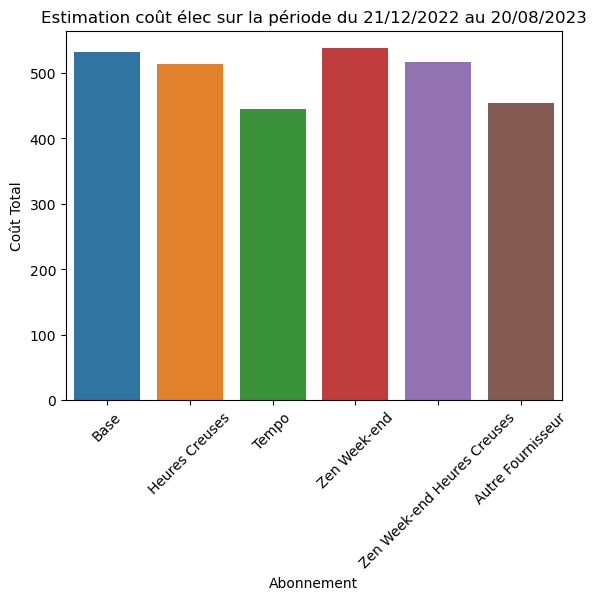

In [65]:
sns.barplot(data=costs, x='Abonnement', y='Coût Total')
plt.title(f"Estimation coût élec sur la période du {date_start} au {date_stop}")
plt.xticks(rotation = 45)

In [66]:
costs.loc[costs["Abonnement"] == offre_actu, "Coût Total"].values[0]

516.49

In [67]:
reference_cost = costs.loc[costs["Abonnement"] == offre_actu, "Coût Total"].values[0]

costs['Pourcentage'] = ((costs['Coût Total'] - reference_cost) / reference_cost) * 100
costs

,Abonnement,Coût Total,Pourcentage
0,Base,532.62,3.123003
1,Heures Creuses,513.08,-0.660226
2,Tempo,445.27,-13.789231
3,Zen Week-end,537.70,4.106565
4,Zen Week-end Heures Creuses,516.49,0.000000
5,Autre Fournisseur,454.14,-12.071870


In [68]:
day_power = data.groupby(pd.to_datetime(data['Horaire'], utc=True).dt.date)['Puissance'].sum() / 2000
day_power = pd.DataFrame(day_power)
day_power.reset_index(inplace=True)

In [69]:
jan_power = day_power.loc[pd.to_datetime(day_power["Horaire"], utc=True).dt.month == 8]

<BarContainer object of 19 artists>

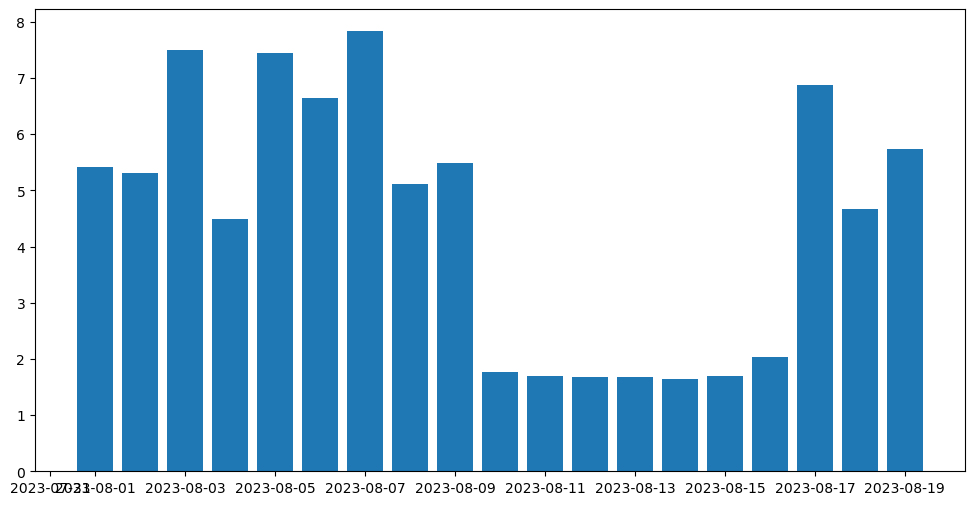

In [70]:
plt.figure(figsize=(12,6))
plt.bar(x=jan_power["Horaire"], height=jan_power["Puissance"])